# 10/22/2015

# Beginning Analysis of Red Disk Fraction over Redshift, starting by using Tom's selection Method


# Section 1: Cross-matching with ULTRAVISTA catalog
## ULTRAVISTA provides k-corrected colors and magnitudes for 339,384 galaxies in the COSMOS field. GZ:Hubble classified 84,350 galaxies in the COSMOS field. Of these, 70,198 were sky-matched in the ULTRAVista catalog (with a max. separation of 1"). 

## link to ULTRAVista data: http://terapix.iap.fr/article.php?id_article=844

## A note: in Tom's work, he claims that 26,452 of these are within a redshift range 0.2 <= z <= 1.0, however I find 51,370 in this range (see below). I'm not sure which z measurement he's going with though - I'm using the 'Z' parameter as described in Griffith's et al. (spec z unless bad, then photoz). 

In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
import scipy.stats.distributions as dist
from matplotlib import ticker

from scipy.optimize import curve_fit
from astropy.io import fits as pyfits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
mpl.rcParams['text.usetex']=True


Populating the interactive namespace from numpy and matplotlib


In [10]:
data = pyfits.open('/home/mel/Documents/GZ_HUBBLE/other_catalogs/ULTRAVISTA/matched_catalog.fits')
data=data[1].data

In [31]:
#update redshift column to take the best version
z='Z_BEST_COMBINED'

In [37]:
data_2_1 = (data[z]>=0.2) & (data[z]<=1.0) 
print 'The number of galaxies in COSMOS between $0.2 < z < 1.0$ is %s'%len(data[data_2_1])


The number of galaxies in COSMOS between $0.2 < z < 1.0$ is 52707


# Section 2: Removing Dusty Galaxies
# Galaxies so far (UV + GZH + 0.2 < z < 1.0): 52,707
## a note: the NUV-MR column in the UV table is a lie...somehow? physically subtracting the MR from NUV column gives the correct values. 

In [13]:
correctable_data=(data['Correctable_Category']=='correctable')

In [14]:
data_2_4 = (data[z]>=0.2) & (data[z]<=.4)# & (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=.8)
data_4_6 = (data[z]>0.4) & (data[z]<=.6) #& (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=.8)
data_6_8 = (data[z]>0.6) & (data[z]<=.8) #& (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=.8)
data_8_1 = (data[z]>0.8) & (data[z]<=1) #& (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=.8)


In [15]:
data_2_4_red = (data[z]>=0.2) & (data[z]<=.4) & (data['MNUV']-data['MR']>4) & (data['MNUV']-data['MR']<(1.6+2.2*(data['MR']-data['MJ'])))
data_4_6_red = (data[z]>0.4) & (data[z]<=.6) & (data['MNUV']-data['MR']>4) & (data['MNUV']-data['MR']<1.6+2.2*(data['MR']-data['MJ']))
data_6_8_red = (data[z]>0.6) & (data[z]<=.8) & (data['MNUV']-data['MR']>4) & (data['MNUV']-data['MR']<1.6+2.2*(data['MR']-data['MJ']))
data_8_1_red = (data[z]>0.8) & (data[z]<=1) & (data['MNUV']-data['MR']>4) & (data['MNUV']-data['MR']<1.6+2.2*(data['MR']-data['MJ']))

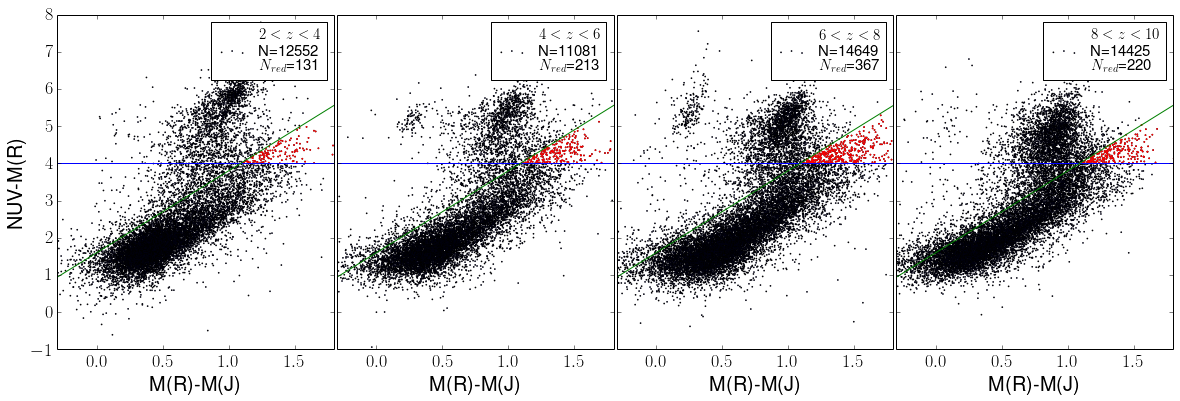

In [16]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

f=plt.figure(figsize=(20,6))
gs=gridspec.GridSpec(1,4)
gs.update(wspace=.01)

data_list=[data_2_4,data_4_6,data_6_8,data_8_1]
data_list_red=[data_2_4_red,data_4_6_red,data_6_8_red,data_8_1_red]

labellist=[2,4,6,8]

x=np.linspace(-1,2,10)
for i in range(0,4):
    ax=plt.subplot(gs[0,i])
    plt.scatter(data[data_list[i]]['MR']-data[data_list[i]]['MJ'],data[data_list[i]]['MNUV']-data[data_list[i]]['MR'],s=.5,label='$%s<z<%s$\nN=%s\n$N_{red}$=%s'%(labellist[i],labellist[i]+2,len(data[data_list[i]]),len(data[data_list_red[i]])))
    plt.scatter(data[data_list_red[i]]['MR']-data[data_list_red[i]]['MJ'],data[data_list_red[i]]['MNUV']-data[data_list_red[i]]['MR'],s=.5,color='r')

    if i!=0:
        plt.tick_params(labelleft='off')
    plt.xlim(-.3,1.8)
    plt.ylim(-1,8)
    plt.xlabel('M(R)-M(J)',fontsize=20)
    if i==0:
        plt.ylabel('NUV-M(R)',fontsize=20)
    plt.legend(numpoints=1,fontsize=15)
    plt.plot(x,4+0*x)
    plt.plot(x,1.6+2.2*x)



In [17]:
red_cut = (data['MNUV']-data['MR']<4) | (data['MNUV']-data['MR']>(1.6+2.2*(data['MR']-data['MJ'])))

data_2_1_red = (data[z]>=0.2) & (data[z]<=1) & red_cut
print 'The number of galaxies after removing dusty galaxies is %s' %len(data[data_2_1_red])

The number of galaxies after removing dusty galaxies is 51774


# Section 3a - Surface Brightness Cut 
## I'm not sure exactly what the best route is here - magnitude or surface brightness. Will try both for now?

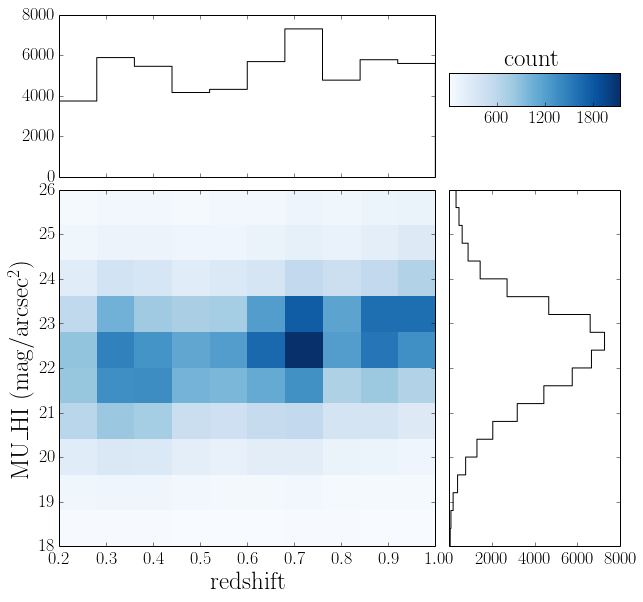

In [19]:
left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width+0.02

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

xlabel = '$\mathrm{redshift}$'
ylabel = '$\mathrm{MU\_HI~(mag/arcsec^2)}$'


fig = plt.figure(1, figsize=(9.5,9))

axTemperature = plt.axes(rect_temperature) # temperature plot
axHistx = plt.axes(rect_histx) # x histogram
axHisty = plt.axes(rect_histy) # y histogram

nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

hist,xedges,yedges=np.histogram2d(data[data_2_1][z],data[data_2_1]['MU_HI'],range=((.2,1),(18,26)))

extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]

cax = axTemperature.imshow(hist.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues)
axHistx.hist(data[data_2_1][z], color = 'k',histtype='step',range=(.2,1))
axHisty.hist(data[data_2_1]['MU_HI'],orientation='horizontal', color = 'k',histtype='step',range=(18,26),bins=20)

axHisty.xaxis.set_major_locator(MaxNLocator(4))
axHistx.yaxis.set_major_locator(MaxNLocator(4))

axTemperature.set_xlabel(xlabel,fontsize=25)
axTemperature.set_ylabel(ylabel,fontsize=25)


cbaxes = fig.add_axes([0.69, 0.8, 0.25, 0.05]) 
cb = plt.colorbar(cax, cax = cbaxes,orientation='horizontal') 
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

fig.text(.77,.86,'$\mathrm{count}$',fontsize=25)
 


In [20]:
SB_cut = (data['MU_HI']<22)
new_sample = (data[z]>=0.2) & (data[z]<=1) & red_cut & SB_cut
print 'Galaxies remaining after applying surface brightness cut: %s'%len(data[new_sample])

Galaxies remaining after applying surface brightness cut: 18579


# Section 3b - Magnitude cut (using Tom's method)
## Plot Mr vs z, find separation between where features are no longer detectable

In [21]:
def zHist3D(xedges,yedges,the_data,colorhist,p):
    newmatrix = np.zeros(shape=(len(yedges)-1,len(xedges)-1))
    for i in range(0,len(yedges)-1):
        for j in range(0,len(xedges)-1):
            data_i_j = (the_data['MR']>=yedges[i]) & (the_data['MR'] < yedges[i+1]) & (the_data[z]>=xedges[j]) & (the_data[z]<xedges[j+1])
            newmatrix[i,j]=np.nanmean(the_data[data_i_j][p])
    newmatrix=ma.masked_where(colorhist.T<50,newmatrix)
    return newmatrix

In [22]:
maghist,xedges,yedges = np.histogram2d(data[z],data['MR'],range=((.1,1.1),(-25,-13)),bins=(10,15))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist_weighted=zHist3D(xedges,yedges,data,maghist,'t01_smooth_or_features_a02_features_or_disk_weighted_fraction')
this_hist_debiased=zHist3D(xedges,yedges,data[correctable_data],maghist,'t01_smooth_or_features_a02_features_or_disk_debiased_fraction')
this_hist_best=zHist3D(xedges,yedges,data,maghist,'t01_smooth_or_features_a02_features_or_disk_best_fraction')

/usr/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:607: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


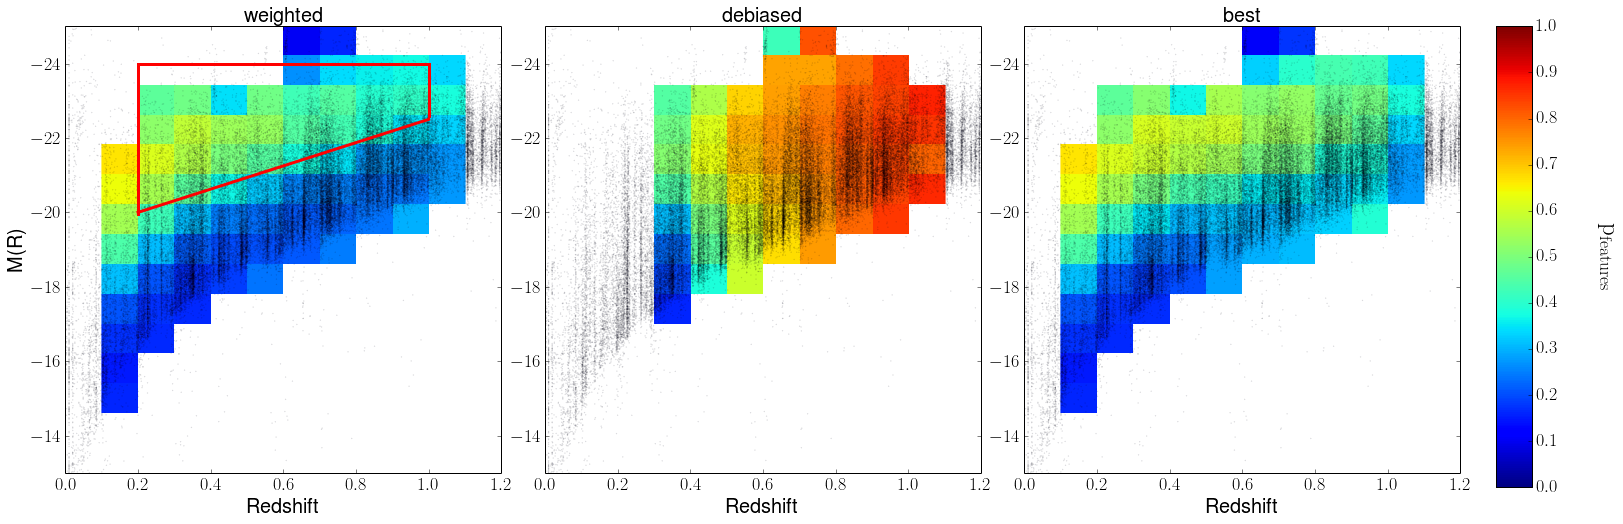

In [23]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

cmap=cm.jet

f=plt.figure(figsize=(25,8))
gs=gridspec.GridSpec(1,3)
gs.update(wspace=.1,hspace=0)

ax1=plt.subplot(gs[0,0])
plt.scatter(data[z],data['MR'],s=.1,alpha=.2)
plt.imshow(this_hist_weighted,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,aspect='auto',cmap=cmap) 
x=np.linspace(.2,1,10)
plt.plot(x,-19.375-3.125*x,c='r',lw=3)
plt.plot(x,-24-0*x,c='r',lw=3)
ymax=-19.375-3.125*.2
plt.axvline(x=.2,ymin=.58,ymax=.91,lw=3,c='r')
plt.axvline(x=1,ymin=.8,ymax=.91,lw=3,c='r')


plt.xlim(0,1.2)
plt.ylim(-25,-13)
plt.xlabel('Redshift',fontsize=20)
plt.ylabel('M(R)',fontsize=20)
plt.title('weighted',fontsize=20)
plt.gca().invert_yaxis()

ax2=plt.subplot(gs[0,1])
plt.scatter(data[z],data['MR'],s=.1,alpha=.2)
plt.imshow(this_hist_debiased,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,aspect='auto',cmap=cmap) 
plt.xlim(0,1.2)
plt.ylim(-25,-13)
plt.xlabel('Redshift',fontsize=20)
plt.title('debiased',fontsize=20)
plt.gca().invert_yaxis()

ax3=plt.subplot(gs[0,2])
plt.scatter(data[z],data['MR'],s=.1,alpha=.2)
im=plt.imshow(this_hist_best,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,aspect='auto',cmap=cmap) 
plt.xlim(0,1.2)
plt.ylim(-25,-13)
plt.xlabel('Redshift',fontsize=20)
plt.title('best',fontsize=20)
plt.gca().invert_yaxis()

cbar_ax = f.add_axes([0.92, 0.1, 0.02, 0.8])
f.colorbar(im, cax=cbar_ax)
f.text(0.98, 0.5, r'$\mathrm{p_{features}}$', ha='center', va='center', rotation=270,fontsize=25)

In [24]:
#Define magnitude cut:
mag_cut = (data['MR'] < -19.375-3.125*data[z] ) & (data['MR']>-24)


In [25]:
new_sample_mag_limited = (data[z]>=.2) & (data[z]<1) & red_cut & mag_cut
print 'Galaxies remaining after applying evolving magnitude cut: %s'%len(data[new_sample_mag_limited])

Galaxies remaining after applying evolving magnitude cut: 11139


# Section 4: Selecting Red Sequence 
## After removing dusty galaxies and applying an evolving magnitude cut, we have a sample of 11,139 galaxies. Now we need to separate them into blue cloud, red sequence, and intermediate / green valley. 

In [32]:
#separate data into bins of fixed redshift, of width dz 
z_min=.2
z_max=1
dz=.2
z_edges=np.linspace(z_min,z_max,(z_max-z_min)/dz+1)
redshift_bin_dct={}
for i in range(0,len(z_edges)-1):
    redshift_bin_dct[float(z_edges[i]),float(z_edges[i+1])] = (data[z]>=float(z_edges[i])) & (data[z]<float(z_edges[i+1])) & mag_cut & red_cut

In [33]:
t=0
for i in range(0,len(z_edges)-1):
    print 'the number of galaxies between redshift %s and %s is %s' %(z_edges[i],z_edges[i+1],len(data[redshift_bin_dct[z_edges[i],z_edges[i+1]]]))
    t+=len(data[redshift_bin_dct[z_edges[i],z_edges[i+1]]])
print 'total is %s'%t

the number of galaxies between redshift 0.2 and 0.4 is 2795
the number of galaxies between redshift 0.4 and 0.6 is 2532
the number of galaxies between redshift 0.6 and 0.8 is 2910
the number of galaxies between redshift 0.8 and 1.0 is 2902
total is 11139


In [34]:
data_list=[]
for i in range(0,len(z_edges)-1):
    data_list.append(redshift_bin_dct[z_edges[i],z_edges[i+1]])

In [35]:
def Hist3D(xedges,yedges,the_data,colorhist):
    newmatrix = np.zeros(shape=(len(yedges)-1,len(xedges)-1))
    for i in range(0,len(yedges)-1):
        for j in range(0,len(xedges)-1):
            data_i_j = (the_data['MNUV']-the_data['MR']>=yedges[i]) & (the_data['MNUV']-the_data['MR'] < yedges[i+1]) & (the_data['MR']>=xedges[j]) & (the_data['MR']<xedges[j+1])
            newmatrix[i,j]=np.average(the_data[data_i_j]['t01_smooth_or_features_a02_features_or_disk_best_fraction'])
    newmatrix=ma.masked_where(colorhist.T<20,newmatrix)
    return newmatrix

In [36]:
colorhist0,xedges,yedges = np.histogram2d(data[data_list[0]]['MR'],data[data_list[0]]['MNUV']-data[data_list[0]]['MR'],range=((-30,-15),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist0=Hist3D(xedges,yedges,data[data_list[0]],colorhist0)

colorhist1,xedges,yedges = np.histogram2d(data[data_list[1]]['MR'],data[data_list[1]]['MNUV']-data[data_list[1]]['MR'],range=((-30,-15),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist1=Hist3D(xedges,yedges,data[data_list[1]],colorhist1)

colorhist2,xedges,yedges = np.histogram2d(data[data_list[2]]['MR'],data[data_list[2]]['MNUV']-data[data_list[2]]['MR'],range=((-30,-15),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist2=Hist3D(xedges,yedges,data[data_list[2]],colorhist2)

colorhist3,xedges,yedges = np.histogram2d(data[data_list[3]]['MR'],data[data_list[3]]['MNUV']-data[data_list[3]]['MR'],range=((-30,-15),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist3=Hist3D(xedges,yedges,data[data_list[3]],colorhist3)

/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


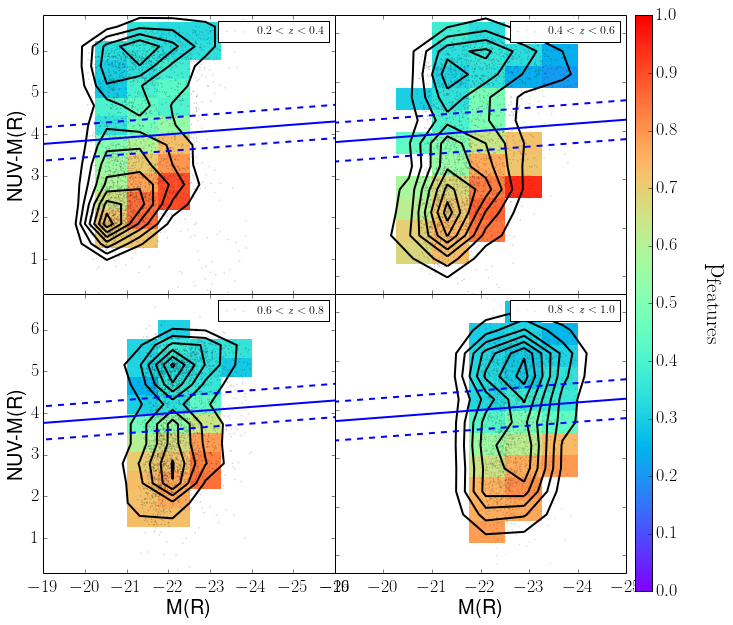

In [38]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

f=plt.figure(figsize=(12,10))
gs=gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)

cmap=cm.rainbow
alpha=.3

gsx=[0,0,1,1]
gsy=[0,1,0,1]
labellist=[2,4,6,8]

x=np.linspace(-40,-10,10)
ax0=plt.subplot(gs[0,0])
plt.scatter(data[data_list[0]]['MR'],data[data_list[0]]['MNUV']-data[data_list[0]]['MR'],s=.1,alpha=alpha,label='$0.2<z<0.4$')
plt.contour(colorhist0.T,extent=extent,colors='k',linewidths=2)
im0=ax0.imshow(this_hist0,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.tick_params(labelbottom='off')
plt.ylabel('NUV-M(R)',fontsize=20)
plt.legend()
plt.gca().invert_xaxis()

ax1=plt.subplot(gs[0,1])
plt.scatter(data[data_list[1]]['MR'],data[data_list[1]]['MNUV']-data[data_list[1]]['MR'],s=.1,alpha=alpha,label='$0.4<z<0.6$')
plt.contour(colorhist1.T,extent=extent,colors='k',linewidths=2)
im1=ax1.imshow(this_hist1,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.tick_params(labelleft='off',labelbottom='off')
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.gca().invert_xaxis()
plt.legend()

ax2=plt.subplot(gs[1,0],sharex=ax0)
plt.scatter(data[data_list[2]]['MR'],data[data_list[2]]['MNUV']-data[data_list[2]]['MR'],s=.1,alpha=alpha,label='$0.6<z<0.8$')
plt.contour(colorhist2.T,extent=extent,colors='k',linewidths=2)
im2=ax2.imshow(this_hist2,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.gca().invert_xaxis()
plt.ylabel('NUV-M(R)',fontsize=20)
plt.xlabel('M(R)',fontsize=20)
plt.legend()

ax3=plt.subplot(gs[1,1],sharex=ax1)
plt.scatter(data[data_list[3]]['MR'],data[data_list[3]]['MNUV']-data[data_list[3]]['MR'],s=.1,alpha=.2,label='$0.8<z<1.0$')
plt.contour(colorhist3.T,extent=extent,colors='k',linewidths=2)
im3=ax3.imshow(this_hist3,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.tick_params(labelleft='off')

        
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-25,-19)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('M(R)',fontsize=20)


f.subplots_adjust(wspace=0, hspace=0,right=.8)
cbar_ax = f.add_axes([0.81, 0.1, 0.02, 0.8])
f.colorbar(im0, cax=cbar_ax)
f.text(0.9, 0.5, r'$\mathrm{p_{features}}$', ha='center', va='center', rotation=270,fontsize=30)

## Now do a fit for each redshift bin instead of one fit for all redshifts

In [143]:
def pdf_model(x, mu1,sig1,mu2,sig2,al_1):
    return al_1*normpdf(x, mu1, sig1) + (1-al_1)*normpdf(x, mu2, sig2)
def fit_histogram(data_list):
    ydata,xdata,hist=plt.hist(data_list,normed=True,histtype='step',color='b')
    #xdata is bin edges, want bin centers
    x_newdata=[]
    for i in range(0,len(xdata)-1):
        x_newdata.append((xdata[i+1]-xdata[i])/2.+xdata[i])
    #now fit gaussian 
    try:
        popt, pcov = curve_fit(pdf_model, x_newdata, ydata)
        #plot fit
        x=np.linspace(0,7,100)
        y=pdf_model(x,popt[0],popt[1],popt[2],popt[3],popt[4])
        plt.plot(x,y,ls='dashed',c='k',lw=3)
    except RuntimeError:
        pass
    
    return None

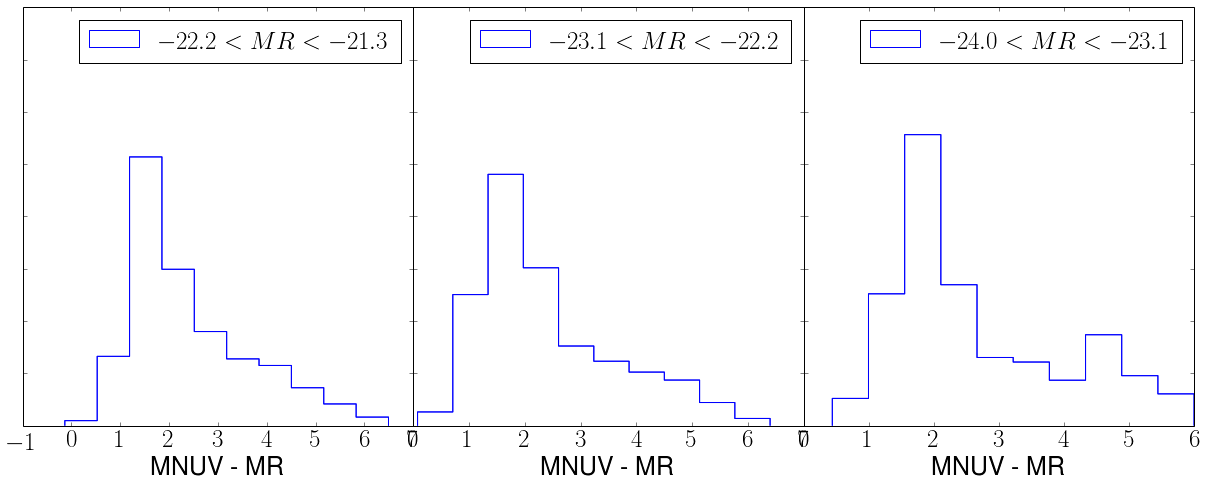

In [148]:
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

zl=2
zh=3

min_MR=np.min(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
max_MR=np.max(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
n_MR_bins=3
MR_edges=np.linspace(min_MR,max_MR,n_MR_bins+1)

gss=[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
gss=gss[::-1]

f=plt.figure(figsize=(28,15))
gs=gridspec.GridSpec(2,4)
gs.update(wspace=0,hspace=0)

for i in range(0,len(MR_edges)-1):
    ax0=plt.subplot(gs[gss[i]])
    data_this_bin=(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']>=MR_edges[i]) &  (data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']<MR_edges[i+1])
    data_list=data[data_this_bin]['MNUV']-data[data_this_bin]['MR']
    try: 
        plt.hist(data[data_this_bin]['MNUV']-data[data_this_bin]['MR'],normed='True',histtype='step',label='$%s<MR<%s$'%(round(MR_edges[i],1),round(MR_edges[i+1],1)))
        fit_histogram(data_list)
    except ValueError:
        pass
    plt.ylim(0,.8)
    plt.legend(fontsize=25)
    
    if i!=3:
        plt.tick_params(labelleft='off')
    if i==7:
        plt.tick_params(labelleft='on')
    if i>3:
        plt.tick_params(labelbottom='off')
    if i<4:
        plt.xlabel('MNUV - MR',fontsize=25)


In [47]:
red_sequence = (data['Z']>=0.2) & (data['Z']<=1) & red_cut & mag_cut & (data['MNUV']-data['MR']>(2.7-.077*data['MR'])) 
blue_cloud = (data['Z']>=0.2) & (data['Z']<=1) & red_cut & mag_cut & (data['MNUV']-data['MR']<(1.9-.077*data['MR'])) 


In [59]:
disk_cut_weighted = (data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']>=.8)
disk_cut_debiased = (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=.8) & correctable_data
disk_cut_best = (data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=.8)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [65]:
all_disks_dct_weighted={}
red_sequence_disks_dct_weighted={}
for z in range(0,len(z_edges)-1):
    all_disks_dct_weighted[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) & red_cut & mag_cut & disk_cut_weighted
    red_sequence_disks_dct_weighted[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) & red_cut & mag_cut & red_sequence & disk_cut_weighted

#only correctable stuff
all_disks_dct_debiased={}
red_sequence_disks_dct_debiased={}
for z in range(0,len(z_edges)-1):
    all_disks_dct_debiased[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) & red_cut & mag_cut  & disk_cut_debiased
    red_sequence_disks_dct_debiased[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) & red_cut & mag_cut & red_sequence & disk_cut_debiased

#all stuff, but use best value 
all_disks_dct_best={}
red_sequence_disks_dct_best={}
for z in range(0,len(z_edges)-1):
    all_disks_dct_best[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1]))  & red_cut & mag_cut  & disk_cut_best
    red_sequence_disks_dct_best[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) &  red_cut & mag_cut & red_sequence & disk_cut_best


In [39]:
red_list = [.3,.5,.7,.9]

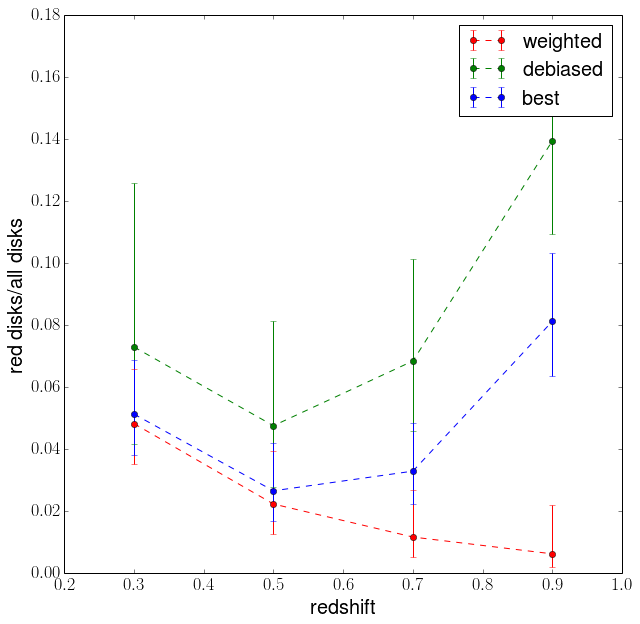

In [66]:
f=plt.figure(figsize=(10,10))
colors=['r','g','b']
fmt='--o'
c=.95
frac_list=[]
yerr_low=[]
yerr_hi=[]
for z in range(0,len(z_edges)-1):
    N_all_disks = len(data[all_disks_dct_weighted[z_edges[z],z_edges[z+1]]]) #n
    N_red_disks = len(data[red_sequence_disks_dct_weighted[z_edges[z],z_edges[z+1]]]) #k
    frac = float(N_red_disks)/N_all_disks
    frac_list.append(frac)
    
    p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    yerr_low.append(frac-p_l)
    yerr_hi.append(p_u-frac)
plt.errorbar(red_list,frac_list,yerr=(yerr_low,yerr_hi),c=colors[0],label='weighted',fmt=fmt)

frac_list=[]
yerr_low=[]
yerr_hi=[]
for z in range(0,len(z_edges)-1):
    N_all_disks = len(data[all_disks_dct_debiased[z_edges[z],z_edges[z+1]]]) #n
    N_red_disks = len(data[red_sequence_disks_dct_debiased[z_edges[z],z_edges[z+1]]]) #k
    frac = float(N_red_disks)/N_all_disks
    frac_list.append(frac)
    
    p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    yerr_low.append(frac-p_l)
    yerr_hi.append(p_u-frac)
plt.errorbar(red_list,frac_list,yerr=(yerr_low,yerr_hi),c=colors[1],label='debiased',fmt=fmt)

frac_list=[]
yerr_low=[]
yerr_hi=[]
for z in range(0,len(z_edges)-1):
    N_all_disks = len(data[all_disks_dct_best[z_edges[z],z_edges[z+1]]]) #n
    N_red_disks = len(data[red_sequence_disks_dct_best[z_edges[z],z_edges[z+1]]]) #k
    frac = float(N_red_disks)/N_all_disks
    frac_list.append(frac)
    
    p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    yerr_low.append(frac-p_l)
    yerr_hi.append(p_u-frac)
plt.errorbar(red_list,frac_list,yerr=(yerr_low,yerr_hi),c=colors[2],label='best',fmt=fmt)
plt.xlim(.2,1)
plt.xlabel('redshift',fontsize=20)
plt.ylabel('red~disks/all~disks',fontsize=20)

plt.legend(fontsize=20)


In [22]:
t=0
for z in range(0,len(z_edges)-1):
    print 'the number of disks galaxies between redshift %s and %s is %s' %(z_edges[z],z_edges[z+1],len(data[all_disks_dct[z_edges[z],z_edges[z+1]]]))
    t+=len(data[all_disks_dct[z_edges[z],z_edges[z+1]]])
print 'total is %s'%t

t=0
for z in range(0,len(z_edges)-1):
    print 'the number of red sequence disks between redshift %s and %s is %s' %(z_edges[z],z_edges[z+1],len(data[red_sequence_disks_dct[z_edges[z],z_edges[z+1]]]))
    t+=len(data[red_sequence_disks_dct[z_edges[z],z_edges[z+1]]])
print 'total is %s'%t

In [20]:
frac_list = [float(len(data[rs_2_4_disks]))/len(data[all_2_4_disks]),float(len(data[rs_4_6_disks]))/len(data[all_4_6_disks]),float(len(data[rs_6_8_disks]))/len(data[all_6_8_disks]),float(len(data[rs_8_1_disks]))/len(data[all_8_1_disks]),]

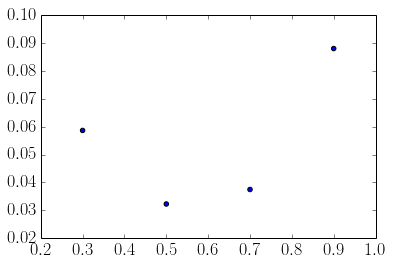

In [23]:
#red disks / all disks, using weighted values to identify disks
#complication: missing a lot of disks. which ones? if color is correlated with magnitude, then we'd be losing 
#the fainter disks, which would be the blue ones: f = N_red / (N_red + N_blue).  
#by adding more faint disks, we'd have more blue disks, so this should decrease the fractions... hmm 

In [ ]:
p_l=dist.beta.ppf((1-c)/2.,k+1,n-k+1)
p_u=dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)

In [50]:
gss

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]

In [51]:
gss[::-1]

[(1, 3), (1, 2), (1, 1), (1, 0), (0, 3), (0, 2), (0, 1), (0, 0)]

In [ ]:
import numpy.ma as ma

In [ ]:
plt.hist(new_data[new_new_data]['MU_HI'])